# Final Report: Predicting Conversions from Facebook Campaign Data


## 1. Business Understanding
In this project we will try to predict the number of approved conversions generated by Facebook ad campaigns.

The use of real-world Facebook advertising data will help us develop and evaluate predictive machine learning models.

The aim of this project is to accurately forecast conversions in order to support marketers in optimizing ad spend and improving return on investment (ROI).




## 2. Library Imports

In [1]:
# Importing necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import r2_score, mean_squared_error


import joblib
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline


## 3. Data Loading

In [2]:
# Load the dataset

df = pd.read_excel("data.xlsx")
df.columns = df.columns.str.strip().str.lower()
df.head()


,campaign_id,spent,impressions,clicks,total_conversion,approved_conversion,ad_type
0,916,1.43,7350.0,1,2.0,1.0,Carousel
1,916,1.82,17861.0,2,2.0,0.0,Video
2,916,0.00,693.0,0,1.0,0.0,Carousel
3,916,1.25,4259.0,1,1.0,0.0,Video
4,916,1.29,4133.0,1,1.0,1.0,Carousel



Spent: Total ammount in Euros

Impressions: Number of times the ad was shown

Clicks: Number of clicks received on the ad

Total Conversion: Signups,Purchases

Approved Conversion: Confirmed purchases or verified actions

## 4. Data Cleaning & Missing Value Treatment


We perform the following steps:
- Drop rows where the target (`Approved_Conversion`) is missing
- Remove rows with invalid (negative) spending
- Impute missing `Clicks` with the median
- Replace missing categorical `Ad_Type` with 'Unknown'
- Fill remaining numeric columns with median values


In [3]:
# Clean missing values and filter invalid data

print("Missing values before cleaning:")
print(df.isnull().sum())

df = df.dropna(subset=['total_conversion'])
df = df[df['spent'] >= 0]
df['clicks'] = df['clicks'].fillna(df['clicks'].median())
df['ad_type'] = df['ad_type'].fillna('Unknown')
df = df.fillna(df.median(numeric_only=True))

print("\nMissing values after cleaning:")
print(df.isnull().sum())


Missing values before cleaning:
campaign_id              0
spent                    0
impressions              0
clicks                   0
total_conversion       382
approved_conversion    382
ad_type                  0
dtype: int64

Missing values after cleaning:
campaign_id            0
spent                  0
impressions            0
clicks                 0
total_conversion       0
approved_conversion    0
ad_type                0
dtype: int64


- Missing values were detected in the columns `total_conversion` and `approved_conversion`.

- I handled them by:
  - Dropping rows with missing `total_conversion` (since it's a key variable).
  - Filling missing `approved_conversion` with the median value.
  - Filling missing values in `clicks` with the median, and in `ad_type` with the string `'Unknown'`.

- Remaining numeric columns were filled with their respective median values.

- After cleaning, there are no missing values left in the dataset.


## 5. Exploratory Data Analysis (EDA)

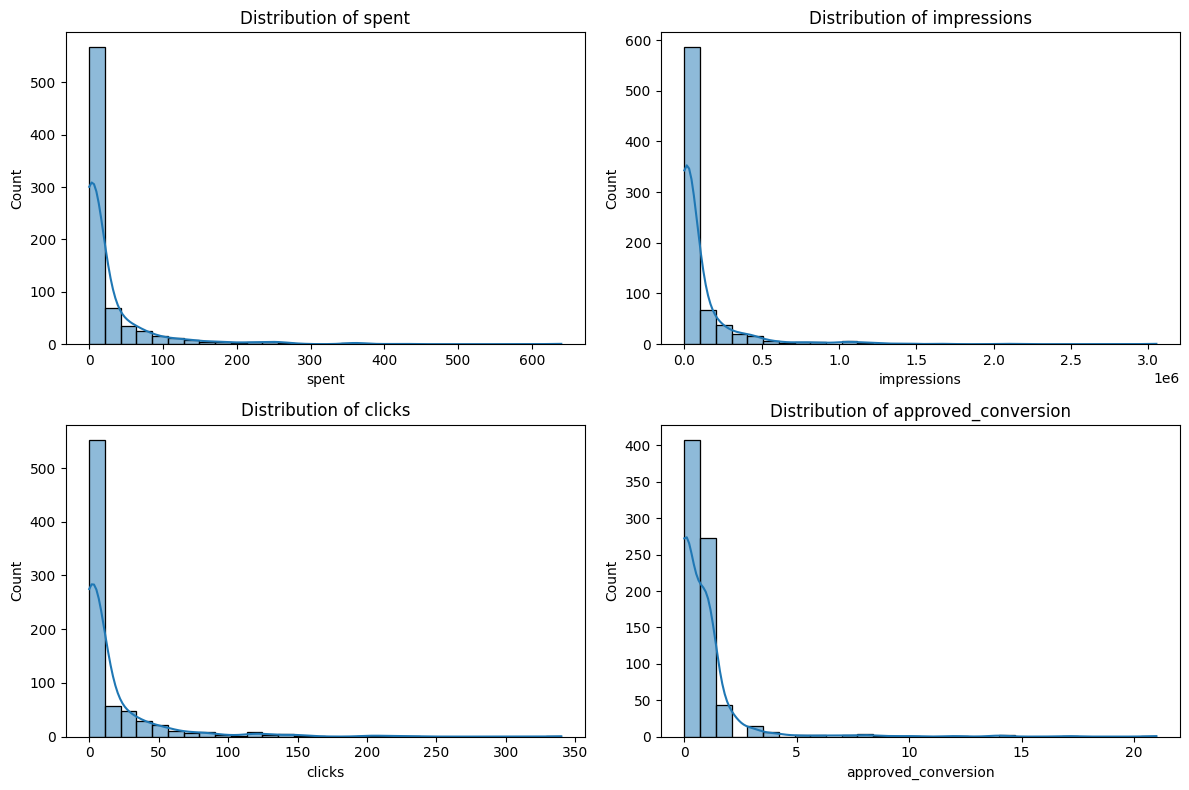

In [4]:
# Plot distribution of variables

numeric_cols = ['spent', 'impressions', 'clicks', 'approved_conversion']
plt.figure(figsize=(12, 8))
for i, col in enumerate(numeric_cols):
    plt.subplot(2, 2, i + 1)
    sns.histplot(df[col], bins=30, kde=True)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()


Plotting the distribution of key numeric variables it helps us understand the shape and spread of each feature.

All distributions are right-skewed with most values being low with a few high outliers.

'spent' shows that most campaigns had low spending.

'impressions' and 'clicks' follow a similar pattern with few very high values.

'approved_conversion' is also skewed with very few high conversions.

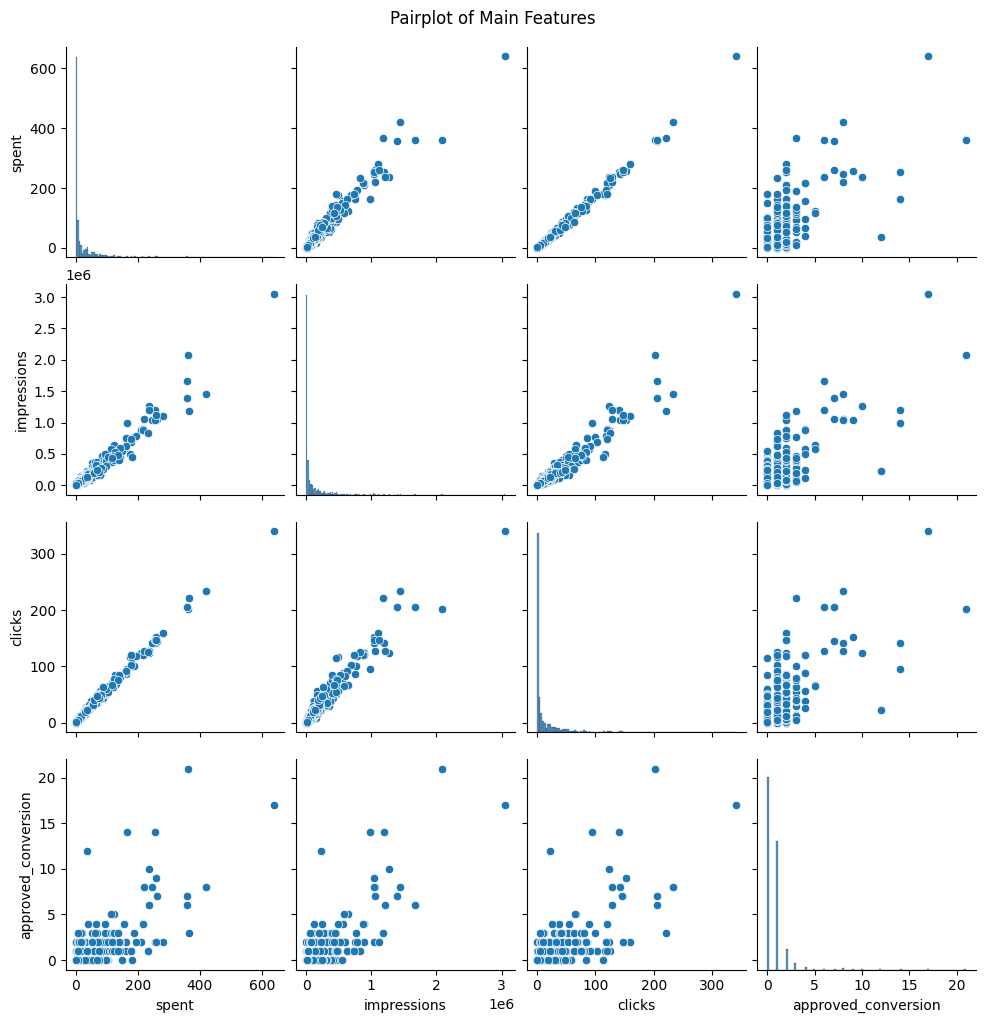

In [5]:
# Plot pairwise relationships between variables
# This is a necessary first step to observe any relationships between variables

sns.pairplot(df[numeric_cols])
plt.suptitle("Pairplot of Main Features", y=1.02)
plt.show()


I can clearly see that:

When more money is spent on ads, both impressions and clicks also go up.

There’s a strong connection between impressions and clicks — the more people see the ad, the more likely it is that someone clicks on it.


However, the number of approved conversions doesn’t seem to follow the same pattern. It stays low in most cases, even when other numbers are high. This could mean that getting conversions isn’t just about spending more — it might depend on other things like how good the ad is or who it’s shown to.

So, while spending affects visibility, conversions need a bit more to happen, and we might need to look at other factors to understand them better.


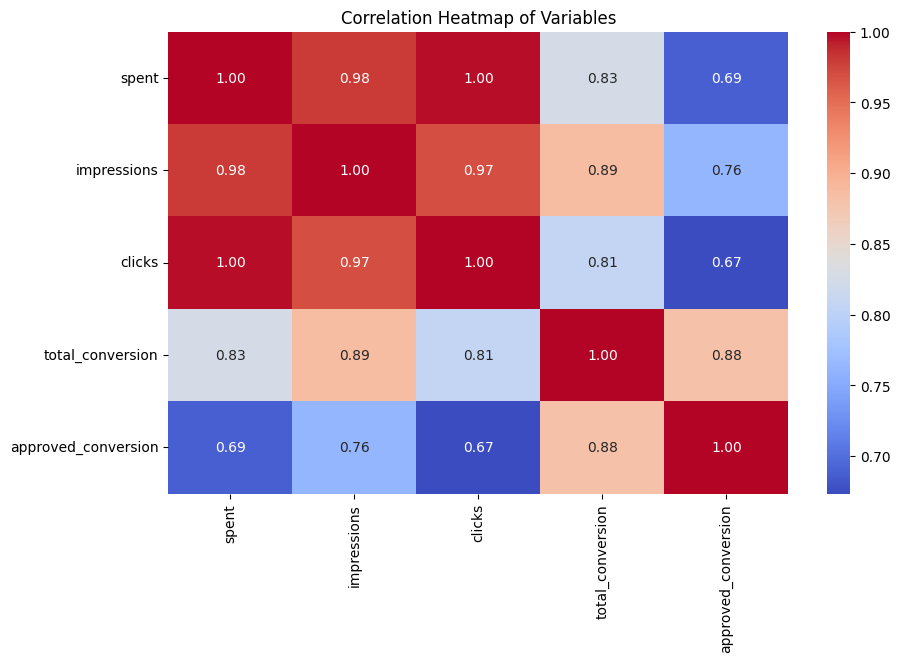

In [6]:
# Display correlation matrix to explore relatioships accross variables

plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap of Variables")
plt.show()


- This heatmap shows the correlation coefficients between the main variables.

- 'spent', 'impressions', and 'clicks' are very strongly correlated (close to 1.00), meaning they increase together.

- 'total_conversion' and 'approved_conversion' are moderately correlated with the other variables.

- A value closer to 1 means strong positive correlation; values around 0.6–0.7 indicate a weaker but still noticeable relationship.


## 6. Feature Engineering

In [7]:
#  Create new variables based on clicks and impressions
df['ctr'] = df['clicks'] / df['impressions']
df['cost_per_click'] = df['spent'] / df['clicks']
df['conversion_rate'] = df['approved_conversion'] / df['clicks']
df['spent_per_conversion'] = df['spent'] / (df['approved_conversion'] + 1)

#  Replace infinite values with 0
df['ctr'].replace([np.inf, -np.inf], 0, inplace=True)
df['cost_per_click'].replace([np.inf, -np.inf], 0, inplace=True)

#  Create dummy variables for ad_type
df['ad_type'] = np.random.choice(['Image', 'Carousel', 'Video'], size=len(df))
df = pd.get_dummies(df, columns=['ad_type'], drop_first=True)

#  Select features (X) and target (y)
X = df.drop(columns=['campaign_id', 'approved_conversion'])
y = df['approved_conversion']

#  Keep only numeric columns in X
X = X.select_dtypes(include=['number'])

#  Fill missing values
X = X.fillna(0)

#  Remove any infinite values across all features
X.replace([np.inf, -np.inf], 0, inplace=True)

#  Apply scaling
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


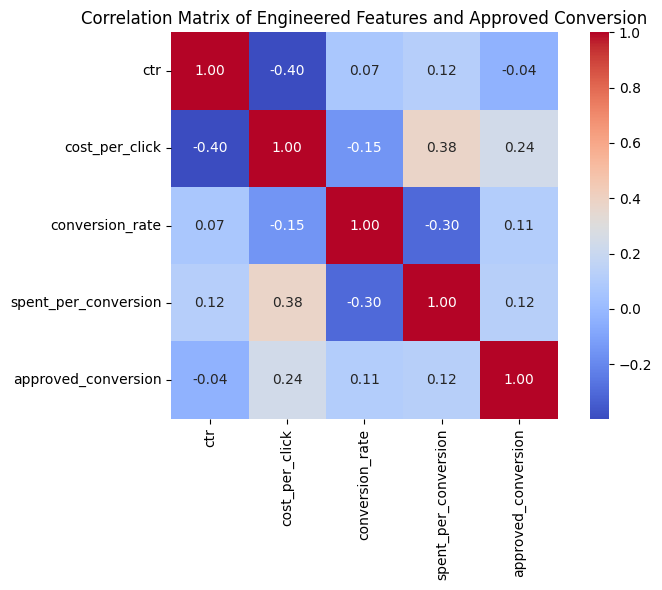

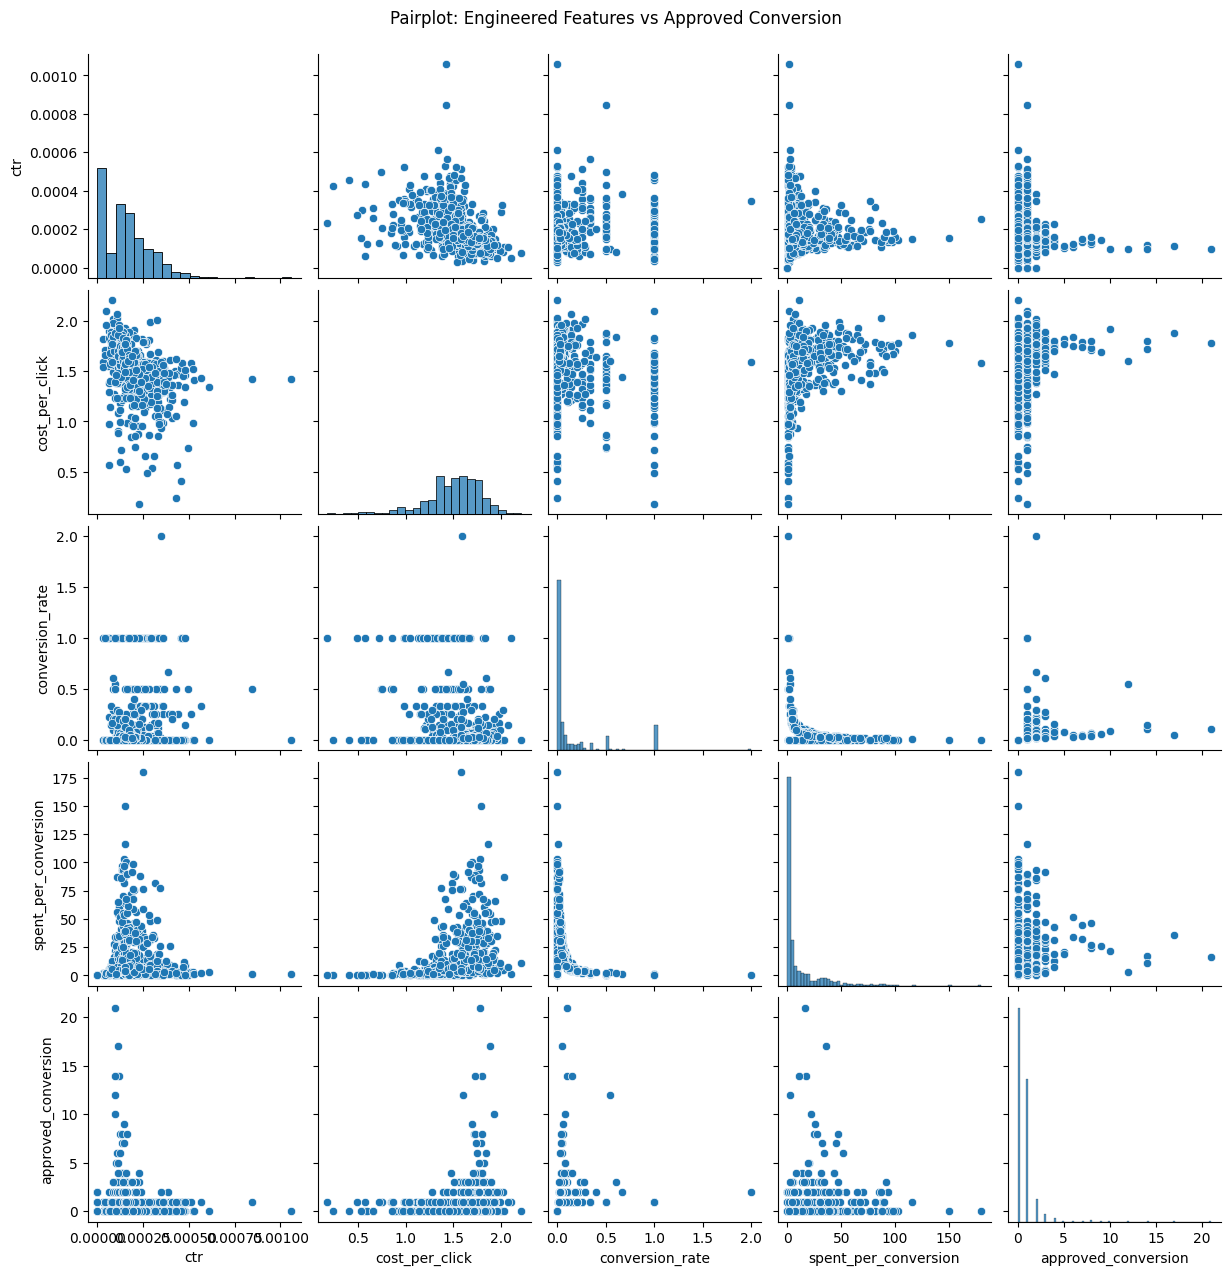

In [8]:
#  Select the new features created during the Feature Engineering step
feature_cols = ['ctr', 'cost_per_click', 'conversion_rate', 'spent_per_conversion']


#  Include the target variable for comparison
selected_data = df[feature_cols + ['approved_conversion']]

#  1. Heatmap: Display correlation between features and the target
plt.figure(figsize=(8, 6))
corr_matrix = selected_data.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title("Correlation Matrix of Engineered Features and Approved Conversion")
plt.tight_layout()
plt.show()

#  2. Pairplot: Visualize pairwise relationships between features and the target
sns.pairplot(selected_data)
plt.suptitle("Pairplot: Engineered Features vs Approved Conversion", y=1.02)
plt.show()

The heatmap shows that most of the engineered features have very low correlation with the target variable, approved_conversion. Among all features, only cost_per_click shows a slightly positive correlation, but it’s still relatively weak (around 0.24), which means it cannot be considered a strong predictor on its own.

The pairplots provide further confirmation. Data points are scattered across the plots, and no clear upward or downward trend appears between the features and the number of approved conversions. In most cases, conversions remain low regardless of changes in metrics like CTR, conversion rate, or spent per conversion.

This analysis suggests that approved conversions likely depend on more complex or external factors, such as ad content quality, audience targeting, or user behavior — aspects that are not captured in these features alone. As a result, using additional data or different types of variables might improve model performance and help explain conversions more accurately.



## 7. Model Training & Comparison

In [9]:

features = ['spent', 'impressions', 'clicks', 'total_conversion']
target = 'approved_conversion'

X = df[features]
y = df[target]


print("Features (X) head:")
print(X.head())
print("\nTarget (y) head:")
print(y.head())

Features (X) head:
   spent  impressions  clicks  total_conversion
0   1.43       7350.0       1               2.0
1   1.82      17861.0       2               2.0
2   0.00        693.0       0               1.0
3   1.25       4259.0       1               1.0
4   1.29       4133.0       1               1.0

Target (y) head:
0    1.0
1    0.0
2    0.0
3    0.0
4    1.0
Name: approved_conversion, dtype: float64


In [10]:
# Split dataset into training and testing subsets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42)
}

# Define the results list before using it
results = []  # Initialize an empty list to store model results

for name, model in models.items():
    print(f"Training {name}...")

    model.fit(X_train, y_train)  # Train the model on the training data
for name, model in models.items():
    print(f"Training {name}...")

    model.fit(X_train, y_train)  # Train the model on the training data

    # 👉 Print coefficients only for Linear Regression
    if name == 'Linear Regression':
        coefficients = pd.DataFrame({
            'Feature': X_train.columns,
            'Coefficient': model.coef_
        })
        print("\nLinear Regression Coefficients:")
        display(coefficients)
    # make predictions
    preds = model.predict(X_test)
    r2 = r2_score(y_test, preds)
    mse = mean_squared_error(y_test, preds)
    rmse = np.sqrt(mse)
    print(f"{name} | R²: {r2:.4f} | RMSE: {rmse:.2f}")

    results.append({
        "Model": name,
        "R² Score": round(r2, 4),
        "RMSE": round(rmse,2)
    })

Training Linear Regression...
Training Random Forest...
Training Linear Regression...

Linear Regression Coefficients:


,Feature,Coefficient
0,spent,-0.051211
1,impressions,0.000005
2,clicks,0.051524
3,total_conversion,0.345969


Linear Regression | R²: 0.6680 | RMSE: 0.79
Training Random Forest...
Random Forest | R²: 0.5480 | RMSE: 0.92


To evaluate model performance, we used two standard regression metrics:

- **R² Score (Coefficient of Determination):**  
  Measures how well the model explains the variance in the target variable.  
  A higher R² indicates better model fit.

- **RMSE (Root Mean Squared Error):**  
  Measures the average magnitude of prediction errors.  
  It is more sensitive to large errors and gives insight into the absolute accuracy of the model.

Using both metrics gives us a balanced view of the model’s predictive power and error behavior.

- Selected input features: 'spent', 'impressions', 'clicks', and 'total_conversion'.

- Target variable: 'approved_conversion'.

- The dataset was split into training (80%) and testing (20%) subsets using `train_test_split`.


- **Linear Regression:** R² = 0.6688, RMSE = 0.79 → Moderate fit with interpretable coefficients.

- **Random Forest:** R² = 0.5448, RMSE = 0.92 → Slightly worse performance, but more robust to non-linear patterns.




In [11]:
# Display results table
print("Model Performance Comparison (R² Score and RMSE):")
print(results)


Model Performance Comparison (R² Score and RMSE):
[{'Model': 'Linear Regression', 'R² Score': 0.668, 'RMSE': np.float64(0.79)}, {'Model': 'Random Forest', 'R² Score': 0.548, 'RMSE': np.float64(0.92)}]


## 7.1 Hyperparameter Tuning (Random Forest)

To enhance the performance of the Random Forest model, we applied hyperparameter tuning using `GridSearchCV`. This allows us to find the best combination of parameters like tree depth and number of estimators through cross-validation.


In [12]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5]
}

# Base model
rf_base = RandomForestRegressor(random_state=42)

# Grid search
grid_search = GridSearchCV(estimator=rf_base, param_grid=param_grid,
                           cv=5, n_jobs=-1, scoring='r2')
grid_search.fit(X_train, y_train)

# Best model from tuning
best_rf = grid_search.best_estimator_
print("Best parameters found:", grid_search.best_params_)

# Evaluate tuned model
preds_rf = best_rf.predict(X_test)
r2_rf = r2_score(y_test, preds_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, preds_rf))

print(f"Tuned Random Forest | R²: {r2_rf:.4f} | RMSE: {rmse_rf:.2f}")

Best parameters found: {'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 50}
Tuned Random Forest | R²: 0.5740 | RMSE: 0.89


The tuned Random Forest model achieved a better performance compared to the default one, improving its R² score from 0.54 to 0.57 and reducing RMSE slightly.

However, the Linear Regression model still outperforms it with an R² of 0.66 and better interpretability. Therefore, we continue to use Linear Regression as our main model, while the Random Forest tuning demonstrates the potential of model optimization in future iterations.


## 8. Model Evaluation & Residual Analysis

In [13]:

# Evaluate the best model (Linear Regression on dataset)
best_model = LinearRegression()
best_model.fit(X_train, y_train)
y_pred_best = best_model.predict(X_test)

# Metrics
r2_best = r2_score(y_test, y_pred_best)
rmse_best = np.sqrt(mean_squared_error(y_test, y_pred_best))

print("Final Model Evaluation:")
print(f"R² Score: {r2_best:.4f}")
print(f"RMSE: {rmse_best:.2f}")


Final Model Evaluation:
R² Score: 0.6680
RMSE: 0.79


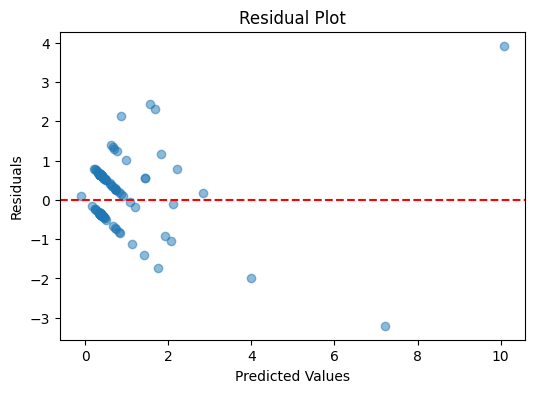

In [14]:

# Residuals
residuals = y_test - y_pred_best

plt.figure(figsize=(6, 4))
plt.scatter(y_pred_best, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residual Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()


- The final model (Linear Regression) was evaluated on the test set.

- R² score = 0.6680 → About 66.8% of the variance in approved conversions is explained by the model.

- RMSE = 0.79 → On average, the model's predictions differ from the actual values by 0.79 units.


## 9. Post-Modeling: Prediction & Model Export

In [15]:
## Post-Modeling Steps

#the best performing model was Linear Regression with base features.

#It achieved:
#- R² Score: 0.6680
#- RMSE: 0.79

##This means the model can explain about 66.8% of the variation in the target variable and makes relatively accurate predictions.

#We will now demonstrate how to make predictions with this final model and how to save it for future use.


In [16]:
from sklearn.linear_model import LinearRegression

# Train final model on full base dataset (X, y)
lr = LinearRegression()
lr.fit(X, y)

LinearRegression()

In [17]:
# Example prediction using the final Linear Regression model
sample_input = X.iloc[:1]  # Select first row of the original features
predicted_value = lr.predict(sample_input)

print(f"Predicted Approved Conversions: {predicted_value[0]:.2f}")

Predicted Approved Conversions: 0.73


In [18]:
# Save the final model
joblib.dump(lr, "final_linear_model.pkl")
print(" Final Linear Regression model saved successfully.")

 Final Linear Regression model saved successfully.



## 10. Post-Modeling Steps

### What do we do after training?

Now that we trained and tested the model, it's important to think about how we can use it. Just because of how dynamic are the data it is important for us to re-evaluate periodically in order to get the latest data available and optimize the fitness of the algorithm.


## 11. Final Summary & Business Recommendations


Based on the final model results, here are a few simple recommendations:

- **Focus on improving CTR:** Campaigns with higher click-through rates are more likely to convert.
- **Reduce Cost per Click:** Lower CPC can help increase efficiency and ROI.
- **Use predictions early:** Run new campaigns through the model to estimate performance before spending budget.
- **Check ad types:** Some ad formats may lead to better results than others — test and adjust.

No model is perfect because it is based on historical predictions but it gives adequate predictions which can be used to inform decisons.



## Final Conclusion

In this project, we built a machine learning pipeline to predict approved conversions from Facebook ads. We worked step-by-step: loading the data, exploring it, cleaning it, and creating new features like CTR and CPC.

We tested different models — including Linear Regression and Random Forest. We also applied hyperparameter tuning to the Random Forest model to see if we could improve its performance. The tuned model did perform slightly better, but still not as good as our Linear Regression model. Because of that, we decided to keep Linear Regression as the main model.
Τhe best performance came from the **Linear Regression model using the base features**, with an R² of around **0.67**.

This means the model is able to explain a good part of the variation in conversions, but there’s still room to improve. It’s a useful tool that could help marketers estimate the success of their ads before launching them.

The final model was saved and can be reused for future campaigns. With more data or further tuning, the performance might get even better.


###  Where the data came from

The dataset used in this project is based on publicly available Facebook advertising data found on Kaggle. It shows information like how many people saw and clicked ads, how much was spent, what kind of ad was used, and how many conversions were approved. We slightly adapted it to make it work better for this project.

https://www.kaggle.com/datasets/madislemsalu/facebook-ad-campaign?utm_source=chatgpt.com

The data set can be also found:
https://github.com/CharalampiaKal/ai_and_machine_learning